---

# Analysis of Perishable Item Sales in Restaurants

This section provides an overview of the dataset used to analyze sales trends of perishable items in restaurants, along with details about preprocessing, decomposition, and data augmentation.

## **1. Datasets Overview**:

We utilize two primary datasets for our analysis:

### **Pizza Sales Dataset**:
- Contains records of daily pizza sales.
- **Date**: Represents the specific day of pizza sales data.
- **Quantity**: Indicates the number of pizzas sold on the respective date.

### **Bakery Sales Dataset**:
- Contains records of daily sales for bakery items.
- **Date**: Represents the specific day of bakery sales data.
- **Quantity**: Indicates the volume of bakery items sold on the respective date.

These datasets not only help in understanding historical sales trends but also serve as a foundation for modeling and prediction.

## **3. Time Series Decomposition**:

Decomposing the time series data provides insights into its various components:

- **Original Series**: Displays the raw sales data.
- **Trend Component**: Shows the underlying trend in sales over time.
- **Seasonal Component**: Represents the regular fluctuations in sales, potentially due to weekly patterns or other recurring events.
- **Residual Component**: Contains the remaining variations in sales after removing the trend and seasonal components.


## **4. Data Augmentation**:

To improve the dataset's coverage and enhance its predictive capabilities, additional data points are generated:
- **Outliers**
- **Backcasting**: Generating past data points using patterns from the existing dataset.
- **Forecasting**: Predicting future data points based on the established trends and patterns.

## **5. Model Training and Initial Validation**:

With the preprocessed and augmented datasets, the model is trained. An initial validation is conducted to assess the model's performance and ensure its reliability before full-scale deployment.

---



## 0.1 Import necessary librearies

In [20]:
# Standard libraries and data processing
import pandas as pd
import numpy as np
from datetime import datetime, timedelta


# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

# Time series analysis
from statsmodels.tsa.seasonal import STL
from scipy.stats import zscore

# Machine learning and deep learning libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Miscellaneous libraries
import holidays
print("Done")


Done


## 1.1 Pizza Sales Dataset

In [21]:
# Load the Excel file
file_path = 'pizza_sales.xlsx'

df = pd.read_excel(file_path)
print('Original Pizza dataframe: ', df)


# Group by order_date and aggregate the quantity and total_price columns
daily_sales = df.groupby('order_date').agg({
    'quantity': 'sum',
    
}).reset_index()
daily_sales = daily_sales.rename(columns={'order_date': 'date'})


print("\n---------------------------------------------------")
print("Cleaned dataframe")
daily_sales

Original Pizza dataframe:         order_details_id  order_id       pizza_id  quantity order_date  \
0                     1         1     hawaiian_m         1 2015-01-01   
1                     2         2  classic_dlx_m         1 2015-01-01   
2                     3         2  five_cheese_l         1 2015-01-01   
3                     4         2    ital_supr_l         1 2015-01-01   
4                     5         2     mexicana_m         1 2015-01-01   
...                 ...       ...            ...       ...        ...   
48615             48616     21348  ckn_alfredo_m         1 2015-12-31   
48616             48617     21348  four_cheese_l         1 2015-12-31   
48617             48618     21348   napolitana_s         1 2015-12-31   
48618             48619     21349     mexicana_l         1 2015-12-31   
48619             48620     21350      bbq_ckn_s         1 2015-12-31   

      order_time  unit_price  total_price pizza_size pizza_category  \
0       11:38:36       13

,date,quantity
0,2015-01-01,162
1,2015-01-02,165
2,2015-01-03,158
3,2015-01-04,106
4,2015-01-05,125
...,...,...
353,2015-12-27,89
354,2015-12-28,102
355,2015-12-29,80
356,2015-12-30,82


## 1.2 Bakery Dataset

In [22]:
# Load the data
df_backery = pd.read_csv('bakery_sales.csv')

print('Original Bakery dataframe: ', df_backery)

# Group by the 'date' column and sum the 'Quantity' for each date
df_backery = df_backery.groupby('date').agg({'Quantity': 'sum'}).reset_index()

# Rename columns for clarity
df_backery.columns = ['date', 'quantity']
df_backery['quantity'] = df_backery['quantity'].astype(int)
df_backery['date'] = pd.to_datetime(df_backery['date'], format='%Y-%m-%d')

print("\n---------------------------------------------------")
print("Cleaned dataframe")# Display the resulting dataframe

df_backery


Original Bakery dataframe:          Unnamed: 0        date   time  ticket_number               article  \
0                0  2021-01-02  08:38       150040.0              BAGUETTE   
1                1  2021-01-02  08:38       150040.0      PAIN AU CHOCOLAT   
2                4  2021-01-02  09:14       150041.0      PAIN AU CHOCOLAT   
3                5  2021-01-02  09:14       150041.0                  PAIN   
4                8  2021-01-02  09:25       150042.0  TRADITIONAL BAGUETTE   
...            ...         ...    ...            ...                   ...   
234000      511387  2022-09-30  18:52       288911.0                 COUPE   
234001      511388  2022-09-30  18:52       288911.0            BOULE 200G   
234002      511389  2022-09-30  18:52       288911.0                 COUPE   
234003      511392  2022-09-30  18:55       288912.0  TRADITIONAL BAGUETTE   
234004      511395  2022-09-30  18:56       288913.0  TRADITIONAL BAGUETTE   

        Quantity unit_price  
0    

,date,quantity
0,2021-01-02,581
1,2021-01-03,564
2,2021-01-04,315
3,2021-01-05,309
4,2021-01-07,310
...,...,...
595,2022-09-26,399
596,2022-09-27,423
597,2022-09-28,357
598,2022-09-29,428


## 2.1 Pizza Sales Dataset Time series Decomposition

In [23]:
# Create a date range for the entire period
complete_date_range = pd.date_range(start=daily_sales["date"].min(), end=daily_sales["date"].max())

# Identify missing dates
missing_dates = complete_date_range[~complete_date_range.isin(daily_sales["date"])]

# Fill in the missing dates
daily_sales_filled = daily_sales.set_index("date").reindex(complete_date_range)
daily_sales_filled.index.name = "date"
daily_sales_filled = daily_sales_filled.interpolate(method="linear").reset_index()

# STL decomposition with a fixed period of 7 days
stl = STL(daily_sales_filled["quantity"], seasonal=7, period=7)
result_pizza = stl.fit()

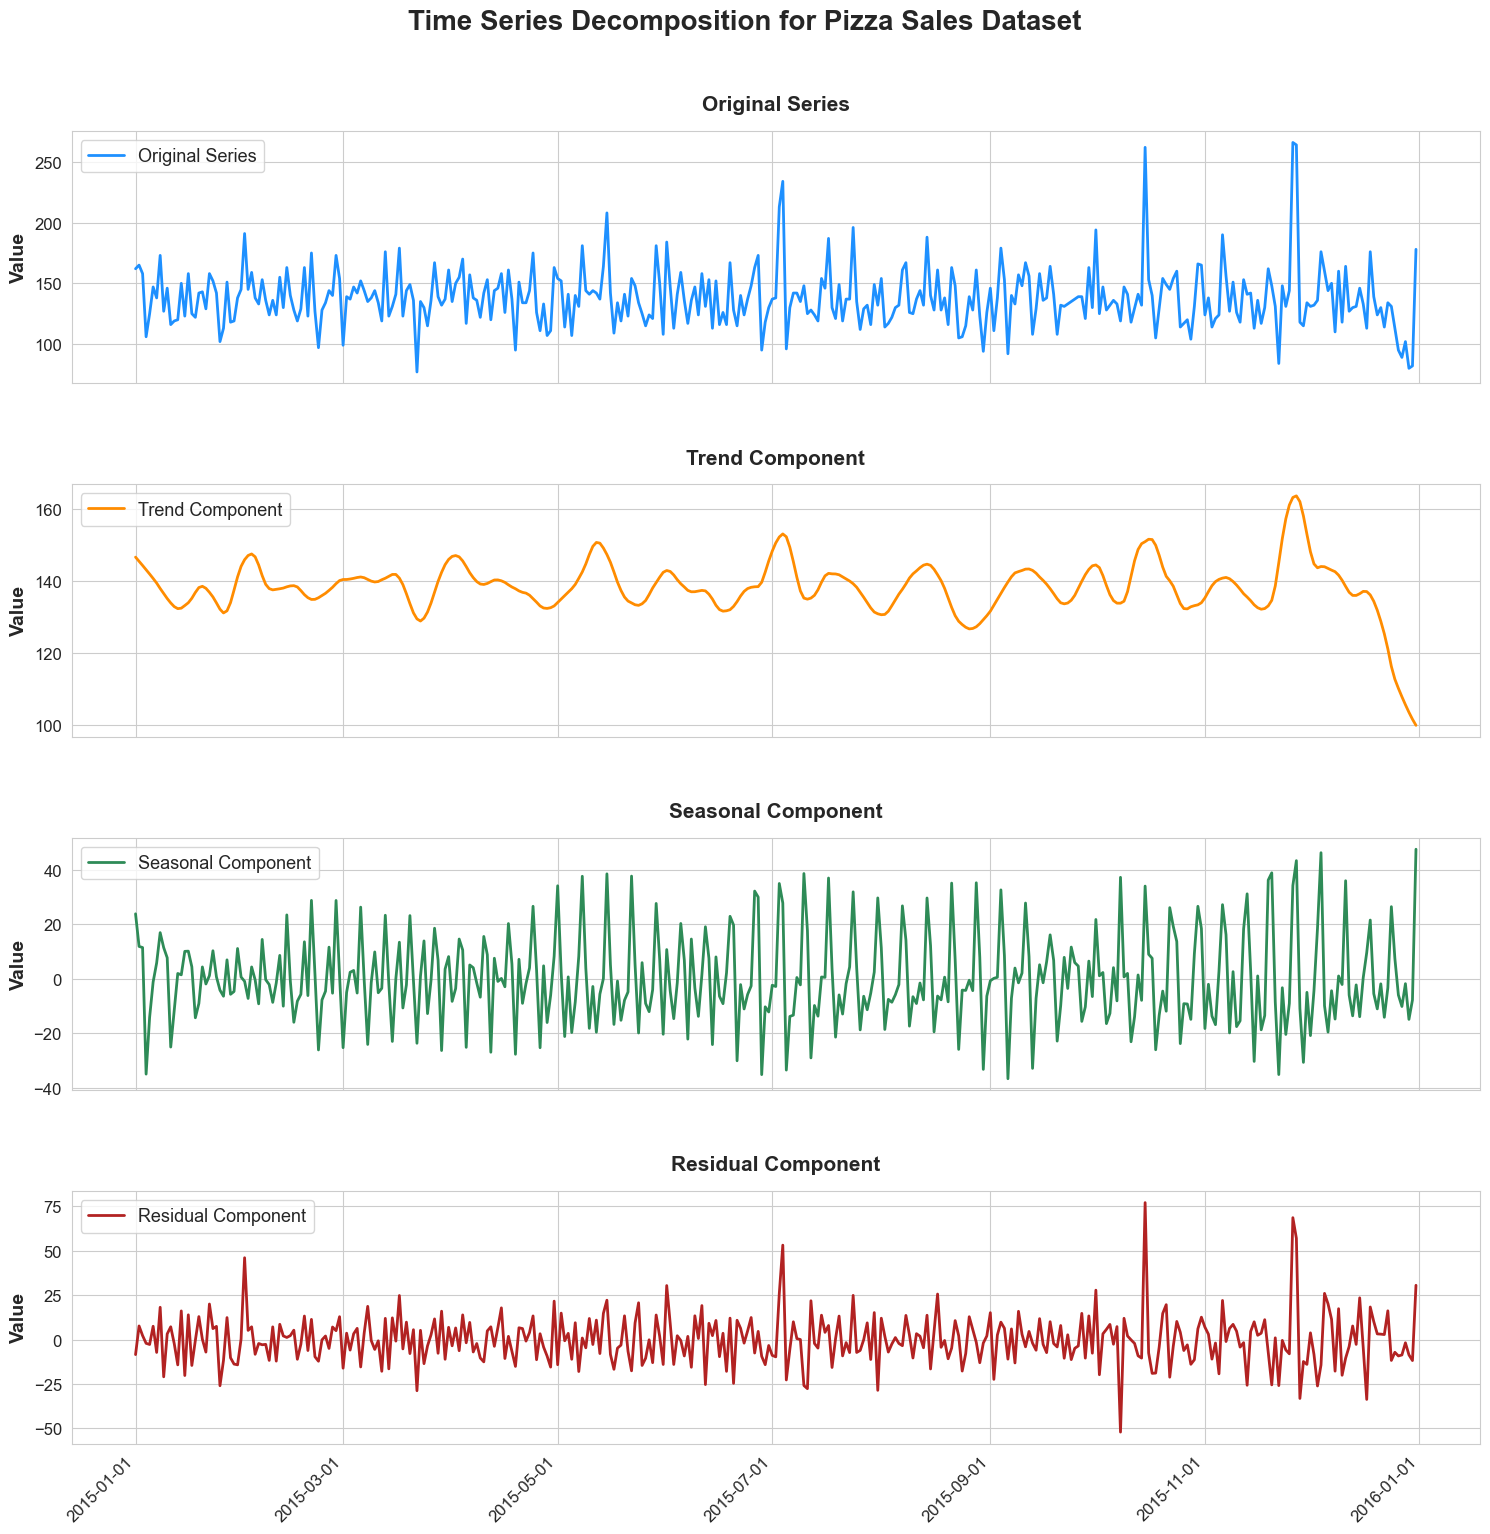

In [24]:

# Set seaborn style
sns.set_style("whitegrid")

# Set a consistent color scheme
colors = ["dodgerblue", "darkorange", "seagreen", "firebrick"]

# Create the subplots with more space
fig, axes = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

# Plot data
components = [("Original Series", daily_sales_filled["quantity"]),
              ("Trend Component", result_pizza.trend),
              ("Seasonal Component", result_pizza.seasonal),
              ("Residual Component", result_pizza.resid)]

# Plot each component
for (title, data), color, ax in zip(components, colors, axes):
    ax.plot(daily_sales_filled["date"], data, label=title, color=color, linewidth=2)
    ax.set_title(title, fontsize=15, fontweight='bold', pad=15)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(loc="upper left", fontsize=13)
    ax.set_ylabel('Value', fontsize=14, fontweight='semibold')

# Limit the number of ticks on the x-axis and format the ticks
date_form = DateFormatter("%Y-%m-%d")
axes[-1].xaxis.set_major_formatter(date_form)

# Rotate x-axis labels for better visibility
plt.setp(axes[-1].get_xticklabels(), rotation=45, ha="right")

# Set a main title for the entire figure
fig.suptitle('Time Series Decomposition for Pizza Sales Dataset', fontsize=20, fontweight='bold', y=1.02)

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)

# Display the plot
plt.show()


## 2.2 Bakery sales Time series Decomposition

In [25]:
# Create a date range for the entire period
complete_date_range = pd.date_range(start=df_backery["date"].min(), end=df_backery["date"].max())

# Identify missing dates
missing_dates = complete_date_range[~complete_date_range.isin(df_backery["date"])]

# Fill in the missing dates
df_backery = df_backery.set_index("date").reindex(complete_date_range)
df_backery.index.name = "date"
df_backery = df_backery.interpolate(method="linear").reset_index()

# STL decomposition with a fixed period of 7 days
stl = STL(df_backery["quantity"], seasonal=7, period=7)
result_bakery = stl.fit()

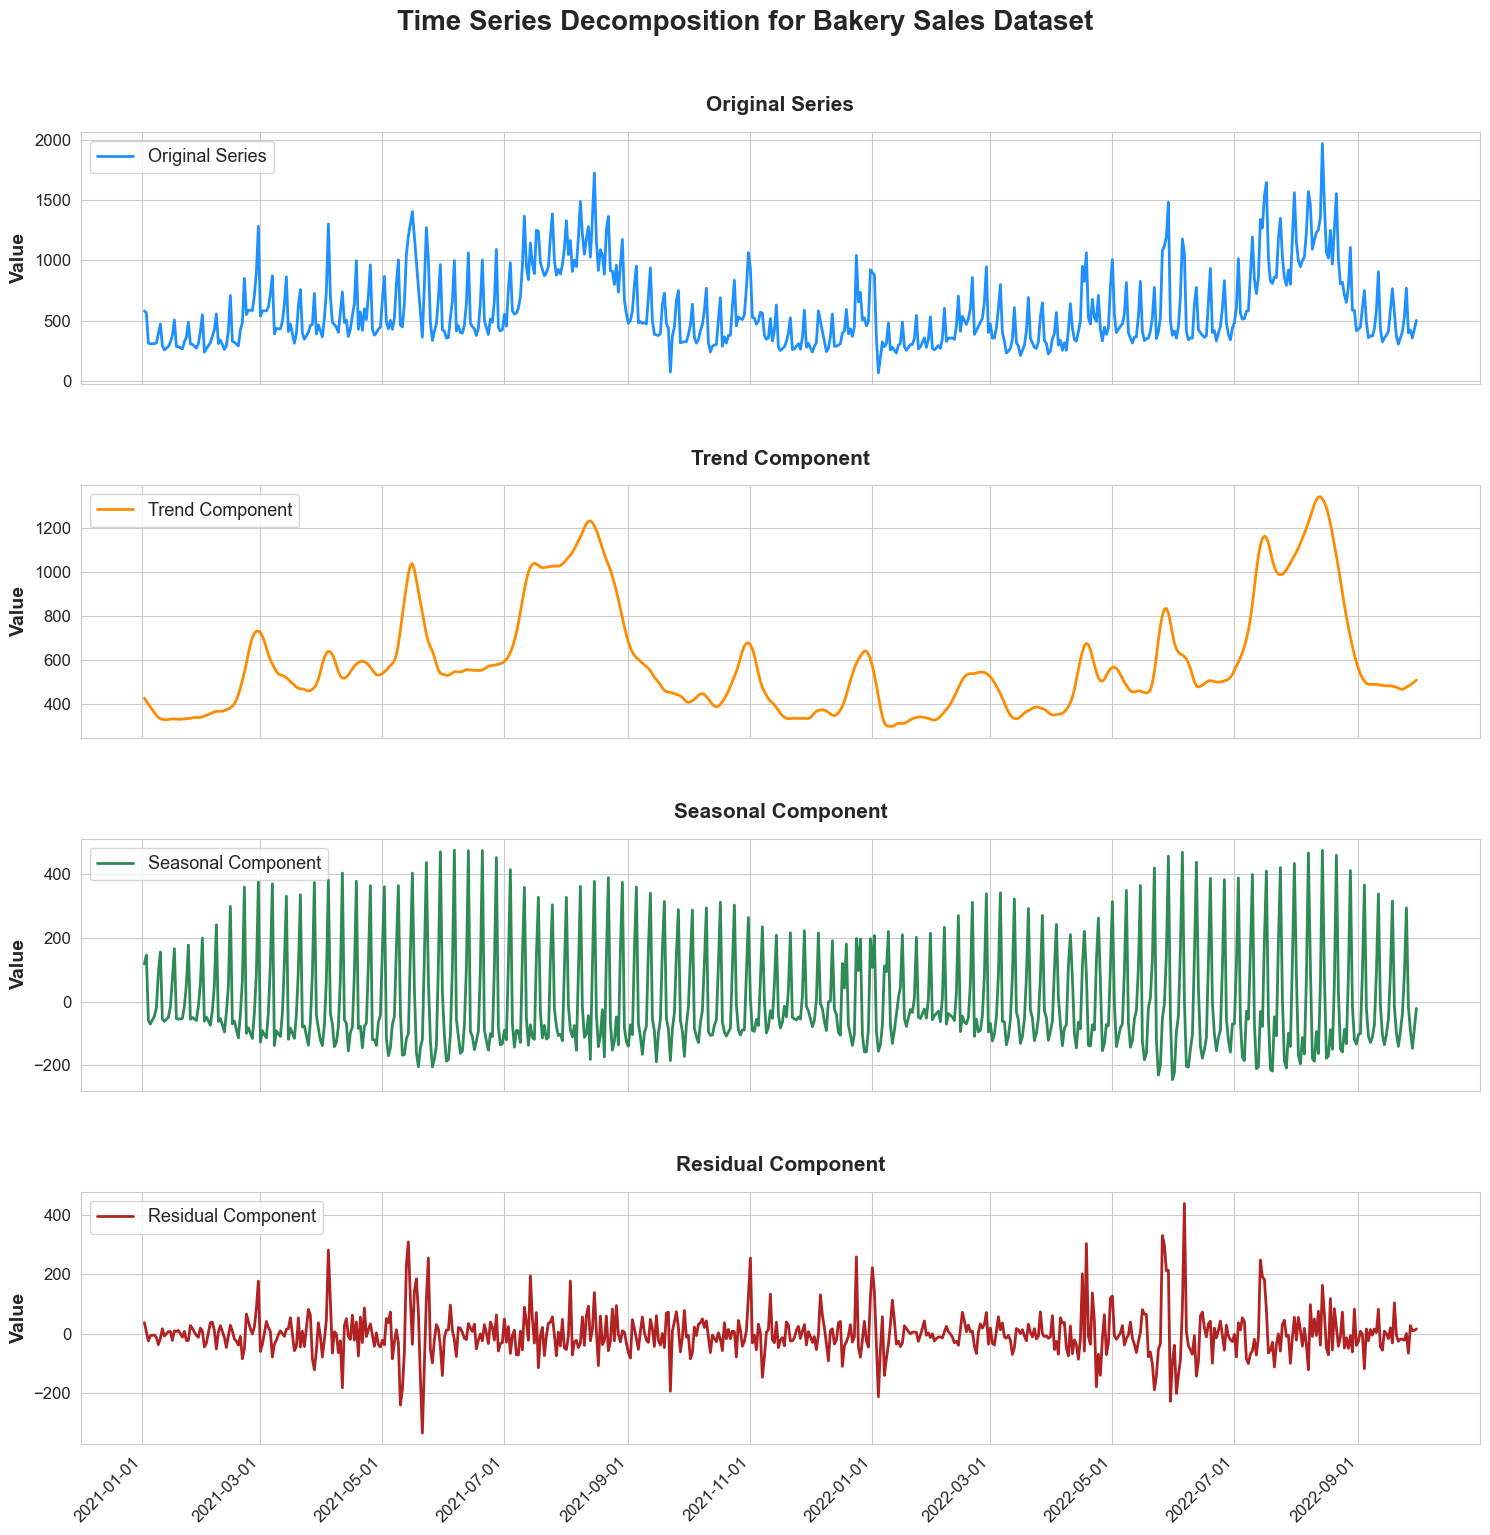

In [26]:
# Set seaborn style
sns.set_style("whitegrid")

# Set a consistent color scheme
colors = ["dodgerblue", "darkorange", "seagreen", "firebrick"]

# Create the subplots with more space
fig, axes = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

# Plot data
components = [("Original Series", df_backery["quantity"]),
              ("Trend Component", result_bakery.trend),
              ("Seasonal Component", result_bakery.seasonal),
              ("Residual Component", result_bakery.resid)]

# Plot each component
for (title, data), color, ax in zip(components, colors, axes):
    ax.plot(df_backery["date"], data, label=title, color=color, linewidth=2)
    ax.set_title(title, fontsize=15, fontweight='bold', pad=15)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(loc="upper left", fontsize=13)
    ax.set_ylabel('Value', fontsize=14, fontweight='semibold')

# Limit the number of ticks on the x-axis and format the ticks
date_form = DateFormatter("%Y-%m-%d")
axes[-1].xaxis.set_major_formatter(date_form)

# Rotate x-axis labels for better visibility
plt.setp(axes[-1].get_xticklabels(), rotation=45, ha="right")

# Set a main title for the entire figure
fig.suptitle('Time Series Decomposition for Bakery Sales Dataset', fontsize=20, fontweight='bold', y=1.02)

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)

# Display the plot
plt.show()


## 3.  Data Augmentation and Outlier Management 
----------------



### 1. Backcasting and Forecasting:
    
    - Using the historical trend and seasonal components extracted from the existing data, 
      we can generate data for periods before and after the known data.
    - Backcasting involves producing data for earlier periods, and forecasting is for later periods.

### 2. Outlier Detection and Management:
    
    - Time series data can often have outliers - values that deviate significantly from the expected range.
    - We calculate the Z-scores for each data point. The Z-score measures how many standard deviations 
      a data point is from the mean.
    - We consider data points with Z-scores beyond a threshold (e.g., |Z-score| > 3) as outliers.

### 3. Visualization:
    
    - Visualizing the augmented data helps in understanding the data structure and identifying any anomalies.
    - We plot the data for a specific year and highlight outliers in a different color to distinguish them easily.

### 4. Outlier Treatment:
   
    - One common method to handle outliers is to replace them with a measure of central tendency, such as the median.
    - We use a rolling window to calculate a localized median around each outlier 
      and then replace the outlier with this median.





In [27]:
def augment_and_clean_data(data, result, start_date, end_date, plot_year, title):
    # Define the date ranges to backcast and forecast
    backcast_range = pd.date_range(start=start_date, end=data["date"].min() - pd.Timedelta(days=1))
    forecast_range = pd.date_range(start=data["date"].max() + pd.Timedelta(days=1), end=end_date)
    
    # Backcasting and Forecasting
    backcast_values = [(result.trend.iloc[i % len(result.trend)] + result.seasonal.iloc[i % len(result.seasonal)]) for i, _ in enumerate(reversed(backcast_range))]
    forecast_values = [(result.trend.iloc[-(i % len(result.trend)) - 1] + result.seasonal.iloc[i % len(result.seasonal)]) for i, _ in enumerate(forecast_range)]
    
    # Combine the backcasted, original, and forecasted data
    augmented_data = pd.DataFrame({
        "date": list(backcast_range) + list(data["date"]) + list(forecast_range),
        "quantity": backcast_values + list(data["quantity"]) + forecast_values
    })
    
    # Detect outliers based on Z-scores
    augmented_data["zscore"] = zscore(augmented_data["quantity"])
    threshold = 3
    augmented_data["is_outlier"] = augmented_data["zscore"].abs() > threshold
    
    # Plotting
    subset_data = augmented_data[augmented_data["date"].dt.year == plot_year]
    sns.set_style("whitegrid")
    sns.set_palette("pastel")
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.plot(subset_data["date"], subset_data["quantity"], label="Sales Data", linewidth=2, color='royalblue', alpha=0.8)
    outliers = subset_data[subset_data["is_outlier"]]
    ax.scatter(outliers["date"], outliers["quantity"], color="firebrick", s=100, edgecolor='black', zorder=5, label='Outliers')
    ax.set_title(title, fontsize=20, fontweight='bold', pad=20)
    ax.set_xlabel("Date", fontsize=16, fontweight='semibold')
    ax.set_ylabel("Quantity", fontsize=16, fontweight='semibold')
    ax.tick_params(axis='both', labelsize=14)
    median_val = subset_data["quantity"].median()
    ax.axhline(y=median_val, color='gray', linestyle='--', label=f"Median Value: {median_val:.2f}")
    ax.legend(fontsize=12, loc="upper left")
    plt.tight_layout()
    plt.show()
    
    # Handle outliers: replace with the median of surrounding data points
    window_size = 3
    medians = augmented_data["quantity"].rolling(window=window_size, center=True).median()
    augmented_data.loc[augmented_data["is_outlier"], "quantity"] = medians[augmented_data["is_outlier"]]
    
    return augmented_data[['date', 'quantity']]


## 3.1 Pizza dataset outliers

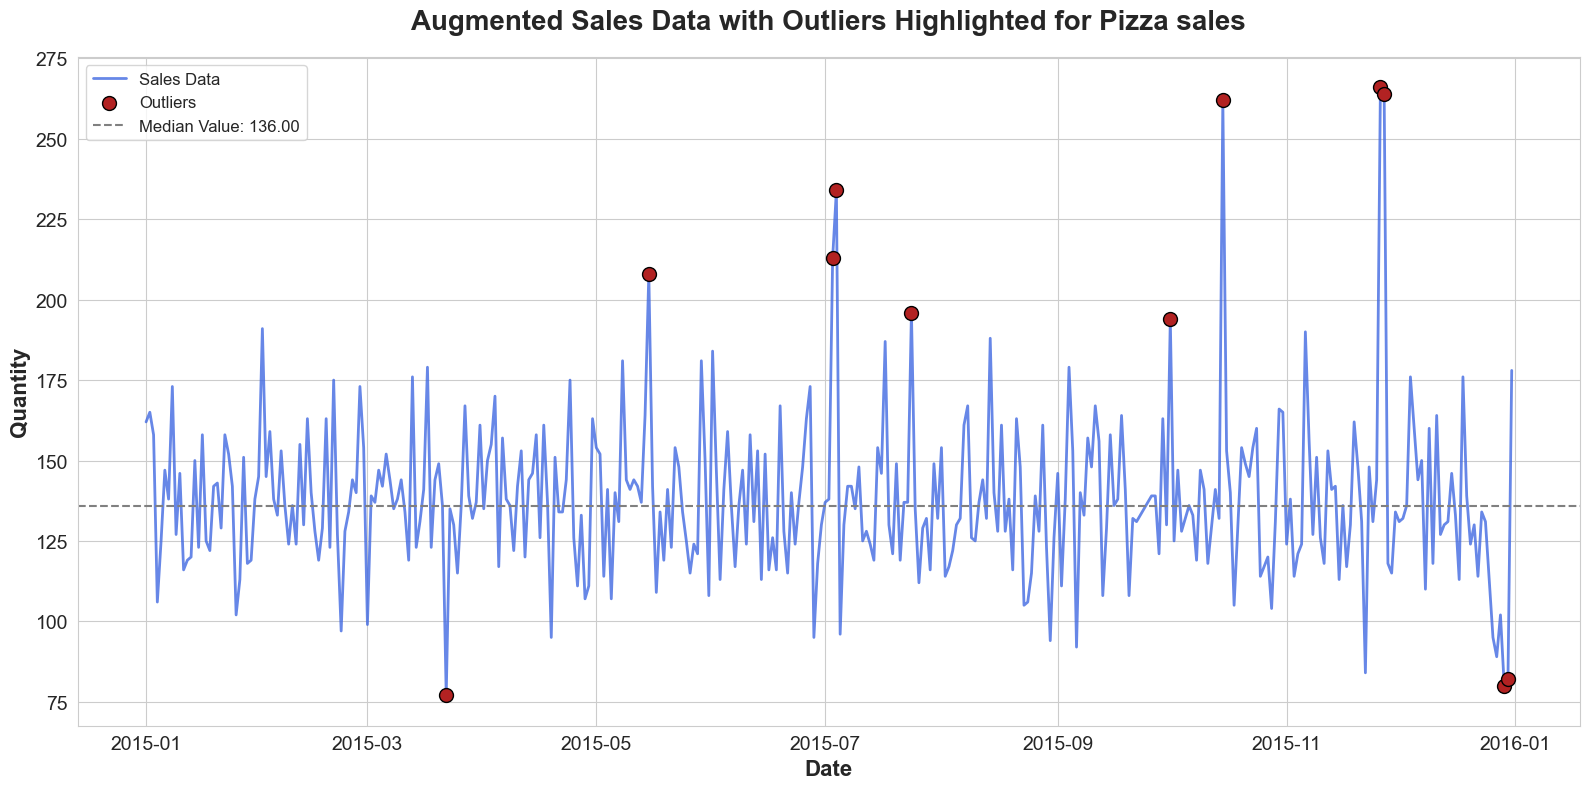

In [28]:
df_pizza = augment_and_clean_data(daily_sales_filled, result_pizza, "2000-01-01", "2020-12-31", 2015, "Augmented Sales Data with Outliers Highlighted for Pizza sales")

In [29]:
df_pizza

,date,quantity
0,2000-01-01,170.442315
1,2000-01-02,157.326777
2,2000-01-03,155.744584
3,2000-01-04,108.092598
4,2000-01-05,127.743851
...,...,...
7666,2020-12-27,129.366701
7667,2020-12-28,137.656924
7668,2020-12-29,137.656924
7669,2020-12-30,123.733819


In [30]:
df_pizza.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7671 entries, 0 to 7670
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      7671 non-null   datetime64[ns]
 1   quantity  7671 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 120.0 KB


## 3.2 Bakery dataset outliers

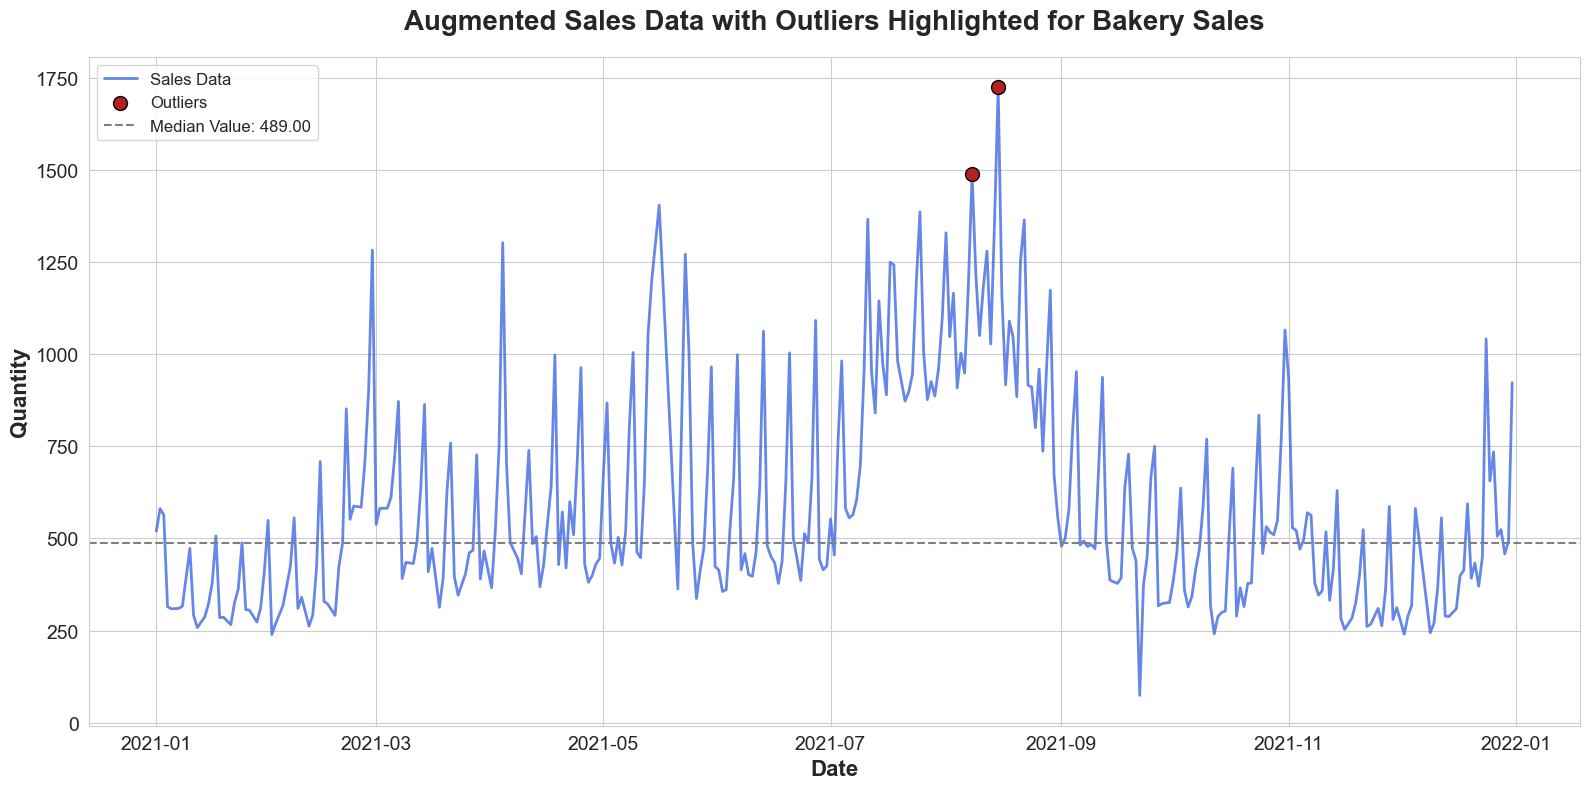

In [31]:
df_bakery = augment_and_clean_data(df_backery, result_bakery, "2005-01-01", "2023-08-28", 2021, "Augmented Sales Data with Outliers Highlighted for Bakery Sales")

In [32]:
df_bakery

,date,quantity
0,2005-01-01,544.312674
1,2005-01-02,558.031620
2,2005-01-03,339.790893
3,2005-01-04,315.557867
4,2005-01-05,315.269951
...,...,...
6809,2023-08-24,427.181231
6810,2023-08-25,448.042127
6811,2023-08-26,556.063481
6812,2023-08-27,803.470561


In [33]:
df_bakery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6814 entries, 0 to 6813
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      6814 non-null   datetime64[ns]
 1   quantity  6814 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 106.6 KB


# FoodSalesPredictor: Class Overview

The `FoodSalesPredictor` class is designed as a comprehensive solution to predict daily sales of perishable items within a restaurant context, encapsulating everything from features engineering to model training and evaluation.

## Dataset Requirements
For this class to function correctly, the input dataset (df) should have the following structure:
   * A DataFrame with two columns :
     - `date`: In datetime format.
     - `quantity`: Numeric representation of daily sales or similar metric.

#### **1. Class Description**:
This class encapsulates methods to preprocess sales data, build a Long Short-Term Memory (LSTM) model, train the model, and make predictions on test data. It also includes utility functions to handle features such as holidays, weekends, and paydays, which can influence daily sales in restaurants.

#### **2. Feature Processing**:
The class focuses on extracting meaningful features from the given sales data:
   * **Seasonality**: Based on the month, the data is categorized into 'Winter', 'Spring', 'Summer', or 'Fall'.
   * **Holidays**: Leveraging the `holidays` library, the data is annotated with a flag indicating if a day is a public holiday.
   * **Weekends**: Days are flagged if they fall on weekends.
   * **Paydays**: Days are flagged if they represent month-ends, which could potentially be paydays.
   * **Lag Features**: The class creates lag features, indicating sales data from previous days, providing context for the model about recent sales trends.

#### **3. Model Creation**:
The choice of model is the LSTM, a type of recurrent neural network (RNN). LSTM is designed to recognize patterns over sequences, making it an optimal choice for time-series forecasting like daily sales predictions.

#### **4. Rationale Behind Model Choice**:
LSTMs have the capability to remember past information, which is essential when predicting sequences with fluctuations, like sales data. The LSTM can utilize its internal memory to process sequences of observations. This makes it suitable for our use-case where past sales data can have an influence on future sales.

#### **5. Model Parameters**:
   * **LSTM Units**: The LSTM layers have units that determine the memory capability and the amount of information they can store.
   * **Dropout**: Dropout layers are introduced to prevent overfitting. They randomly set a fraction rate of input units to 0 at each update during training time.
   * **Dense Layer**: This is the output layer, which provides the final prediction. It uses a linear activation function.

In essence, the `FoodSalesPredictor` serves as a one-stop solution for building a robust perishable item sales forecasting system.


In [34]:
class FoodSalesPredictor:
    def __init__(self, df):
        self.df = df.copy()
        self.quantity_scaler = MinMaxScaler(feature_range=(0, 1))
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.look_back = 20
        self.model = None

    def get_season(self, date):
        """ get season feature for the df"""
        
        if date.month in [12, 1, 2]:
            return 'Winter'
        elif date.month in [3, 4, 5]:
            return 'Spring'
        elif date.month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'

    def preprocess_data(self):
        """Process the df extracting new features splitting the df in 90% train and 10% test"""
        
        us_holidays = holidays.US(years=self.df['date'].dt.year.unique())
        self.df['is_holiday'] = self.df['date'].apply(lambda x: 1 if x in us_holidays else 0)
        self.df['is_weekend'] = self.df['date'].apply(lambda x: 1 if x.weekday() >= 5 else 0)
        self.df['is_paycheck'] = self.df['date'].apply(lambda x: 1 if x.is_month_end else 0)
        self.df['season'] = self.df['date'].apply(self.get_season)

        # Create lag features
        n_lags = 7
        for i in range(1, n_lags + 1):
            self.df[f'lag_{i}'] = self.df['quantity'].shift(i)

        self.df.dropna(inplace=True)
        self.df = pd.get_dummies(self.df, columns=['season'])

        # Scale the 'quantity' column
        self.df['quantity'] = self.quantity_scaler.fit_transform(self.df[['quantity']])

        # Normalize the entire dataframe
        scaled_data = self.scaler.fit_transform(self.df.drop(columns='date'))
        
        # Determine the correct index for 'quantity' column after one-hot encoding
        quantity_col_index = list(self.df.columns).index('quantity')

        X, Y = [], []
        for i in range(len(scaled_data)-self.look_back):
            X.append(scaled_data[i:(i+self.look_back), :-1])
            Y.append(scaled_data[i + self.look_back, quantity_col_index-1])

        self.X = np.array(X)
        self.Y = np.array(Y)
        
        train_size = int(len(self.X) * 0.90)
        test_size = len(self.X) - train_size
        
        self.X_train, self.X_test = self.X[0:train_size], self.X[train_size:len(X)]
        self.Y_train, self.Y_test = self.Y[0:train_size], self.Y[train_size:len(Y)]

        
        
    def preprocess_all_data(self):
        """Process the df extracting new features without splitting the df for training"""
        
        us_holidays = holidays.US(years=self.df['date'].dt.year.unique())
        self.df['is_holiday'] = self.df['date'].apply(lambda x: 1 if x in us_holidays else 0)
        self.df['is_weekend'] = self.df['date'].apply(lambda x: 1 if x.weekday() >= 5 else 0)
        self.df['is_paycheck'] = self.df['date'].apply(lambda x: 1 if x.is_month_end else 0)
        self.df['season'] = self.df['date'].apply(self.get_season)

        # Create lag features
        n_lags = 7
        for i in range(1, n_lags + 1):
            self.df[f'lag_{i}'] = self.df['quantity'].shift(i)

        self.df.dropna(inplace=True)

        # Create one-hot encoded columns for all seasons manually
        seasons = ['Winter', 'Spring', 'Summer', 'Fall']
        for season in seasons:
            self.df[f'season_{season}'] = self.df['season'].apply(lambda x: 1 if x == season else 0)

        self.df.drop(columns=['season'], inplace=True)
        
        # Scale the 'quantity' column
        self.df['quantity'] = self.quantity_scaler.fit_transform(self.df[['quantity']])
        
        scaled_data = self.scaler.fit_transform(self.df.drop(columns='date'))
        
        # Determine the correct index for 'quantity' column after one-hot encoding
        quantity_col_index = list(self.df.columns).index('quantity')

        X, Y = [], []
        for i in range(len(scaled_data)-self.look_back):
            X.append(scaled_data[i:(i+self.look_back), :-1])
            Y.append(scaled_data[i + self.look_back, quantity_col_index-1])

        
        self.X = np.array(X)
        self.Y = np.array(Y)

    def build_model(self, lstm_units=50):
        """Build simplified LSTM model with fewer dense layers"""

        self.model = Sequential()
        input_shape = self.X_train.shape if hasattr(self, 'X_train') else self.X.shape

        self.model.add(LSTM(lstm_units, input_shape=(input_shape[1], input_shape[2]), return_sequences=True))
        self.model.add(Dropout(0.4))

        self.model.add(LSTM(100, return_sequences=False))
        self.model.add(Dropout(0.4))

        self.model.add(Dense(1))

        self.model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.legacy.Adam())

       
    def train_model(self, epochs=200, batch_size=264):
        self.model.fit(self.X_train, self.Y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    def make_predictions(self):
        predictions = self.model.predict(self.X_test)
        predictions = self.quantity_scaler.inverse_transform(predictions)
        Y_test_inv = self.quantity_scaler.inverse_transform(self.Y_test.reshape(-1,1))
        return predictions, Y_test_inv

    def make_predictions_on_all_data(self):
        predictions = self.model.predict(self.X)
        predictions = self.quantity_scaler.inverse_transform(predictions)
        Y_all_inv = self.quantity_scaler.inverse_transform(self.Y.reshape(-1, 1))
        return predictions, Y_all_inv
    
    def aggregate_to_monthly(self, daily_data, date_column):
        """Aggregate daily data to monthly."""
        
        df = pd.DataFrame({
            'date': date_column,
            'daily_data': daily_data.reshape(-1,)
        })
        df['month_year'] = df['date'].dt.to_period('M')
        monthly_data = df.groupby('month_year').daily_data.sum().reset_index()
        return monthly_data['month_year'], monthly_data['daily_data']

    def calculate_all_metrics(self):
        """Calculate all the required methrics"""
        
        def mean_absolute_percentage_error(y_true, y_pred): 
            y_true, y_pred = np.array(y_true), np.array(y_pred)
            return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

        def predictive_tolerance(y_true, y_pred, tolerance_percent=30):
            y_true, y_pred = np.array(y_true), np.array(y_pred)
            lower_bound = y_true * (1 - tolerance_percent/100)
            upper_bound = y_true * (1 + tolerance_percent/100)
            return np.mean((y_pred >= lower_bound) & (y_pred <= upper_bound)) * 100

        def rmse_percentage(y_true, y_pred):
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            return (rmse / np.mean(y_true)) * 100

        Y_test_inv = self.quantity_scaler.inverse_transform(self.Y_test.reshape(-1,1))
        predictions = self.model.predict(self.X_test)
        predictions = self.quantity_scaler.inverse_transform(predictions)

        mape = mean_absolute_percentage_error(Y_test_inv, predictions)
        tolerance = predictive_tolerance(Y_test_inv, predictions, tolerance_percent=30)
        rmse_percent = rmse_percentage(Y_test_inv, predictions)

        metrics = {
            "MAPE": mape,
            "Predictive Tolerance (within 30%)": tolerance,
            "RMSE Percentage": rmse_percent,
        }

        return metrics
    
    

    def test_model_on_new_data(self, df_backery):
        """ Test the model on a new unseen df without splitting in train and test."""
        
        original_df = self.df
        self.df = df_backery
        self.preprocess_all_data()

        predictions, Y_all_inv = self.make_predictions_on_all_data()

        if not hasattr(self, 'X_test') or not hasattr(self, 'Y_test'):
            self.X_test = self.X
            self.Y_test = self.Y

        # Calculate metrics
        metrics = self.calculate_all_metrics()
    
        # Restore original dataframe
        self.df = original_df
        
        # Calculate monthly metrics if needed
        
        return metrics, predictions

    
    def save_model(self, filepath):
        """Saves the trained model to the specified filepath."""
        
        if self.model:
            self.model.save(filepath)
        else:
            print("Model not found!")
    
    def load_pretrained_model(self, filepath):
        """Loads a pre-trained model from the specified filepath."""
        
        self.model = load_model(filepath)
        
    def save_model_weights(self, filepath):
        """Saves the trained model's weights to the specified filepath."""
        
        if self.model:
            self.model.save_weights(filepath)
        else:
            print("Model not found!")
            
    def load_model_weights(self, filepath):
        """Loads the model's weights from the specified filepath."""
        
        if self.model:
            self.model.load_weights(filepath)
        else:
            print("Model hasn't been constructed yet. Create model before loading weights.")

# Model Training for Daily Sales Prediction

------

### Pizza Sales Prediction

**Initialization**: 
We initialized a dedicated predictor for daily pizza sales using the `DailySalePredictor` framework.

**Data Preprocessing**: 
The dataset underwent a comprehensive preprocessing phase, ensuring it was primed for the modeling process. This involved tasks such as scaling features, handling potential outliers or missing values, and segregating the data into training and test sets.

**Model Architecture**:
The predictor employs a well-structured architecture tailored for time series data, ensuring it can capture the underlying patterns and seasonality, if present, in the sales data.

**Training**:
The model was trained using the preprocessed pizza sales dataset, optimizing for a balance between bias and variance to ensure generalizability.

**Saving and Archiving**:
Post-training, both the model's architecture and its learned parameters (weights) were archived. This ensures reproducibility and allows for reusability in future predictions or further tuning.

**Evaluation and Metrics**:
Performance metrics were computed post-training using a holdout test set. This allowed for an unbiased evaluation of the model's predictive capabilities.

**Visualization**:
An integral part of our evaluation was visualizing the actual versus predicted sales. This visual inspection provided an immediate sense of how well our model was approximating real-world sales dynamics.

---

### Transfer Learning for Bakery Sales Prediction

**Initialization for Bakery**:
Given the similarities in predicting sales for different food items, we decided to leverage transfer learning. A new predictor was initialized for bakery sales.

**Data Preprocessing**:
Similar to the pizza dataset, the bakery sales data was subjected to a thorough preprocessing routine.

**Transfer and Fine-tuning**:
Instead of building a model from scratch, we transferred the learned features and patterns from the pizza model. This served as our starting point. The model was then fine-tuned using the bakery sales data, allowing it to adapt and specialize in predicting bakery sales.

**Saving After Fine-tuning**:
The fine-tuned model, now specialized for bakery sales, was archived, preserving both its architecture and learned parameters.

**Evaluation for Bakery**:
Just like the pizza model, we evaluated the bakery sales predictor using a holdout test set and computed various performance metrics.

**Visualization**:
A visual representation of the actual vs. predicted bakery sales was created, providing a clear picture of the model's proficiency in the bakery context.

---

In summary, our approach utilized the power of transfer learning, beginning with a base model trained on pizza sales and subsequently fine-tuning it for bakery sales predictions. This method capitalizes on the shared underlying patterns between datasets, leading to efficient and effective modeling.


In [35]:
pizza_predictor = FoodSalesPredictor(df_pizza)

#Process the data
pizza_predictor.preprocess_data()

pizza_predictor.build_model()
pizza_predictor.train_model()

pizza_predictor.save_model("bakery_predictor.keras")
pizza_predictor.save_model_weights("model_weights.h5")

Epoch 1/200
27/27 [==============================] - 4s 48ms/step - loss: 0.0225
Epoch 2/200
27/27 [==============================] - 1s 45ms/step - loss: 0.0125
Epoch 3/200
27/27 [==============================] - 1s 44ms/step - loss: 0.0115
Epoch 4/200
27/27 [==============================] - 1s 45ms/step - loss: 0.0113
Epoch 5/200
27/27 [==============================] - 1s 45ms/step - loss: 0.0111
Epoch 6/200
27/27 [==============================] - 1s 45ms/step - loss: 0.0106
Epoch 7/200
27/27 [==============================] - 1s 45ms/step - loss: 0.0106
Epoch 8/200
27/27 [==============================] - 1s 44ms/step - loss: 0.0103
Epoch 9/200
27/27 [==============================] - 1s 46ms/step - loss: 0.0103
Epoch 10/200
27/27 [==============================] - 1s 48ms/step - loss: 0.0100
Epoch 11/200
27/27 [==============================] - 1s 48ms/step - loss: 0.0100
Epoch 12/200
27/27 [==============================] - 1s 46ms/step - loss: 0.0096
Epoch 13/200
27/27 [=====

In [36]:
# Get predictions and actuals
predictions1, Y_test_inv = pizza_predictor.make_predictions()

# Calculate metrics using the provided predictions and actuals
metrics1 = pizza_predictor.calculate_all_metrics()

# Print metrics
print("\n===== Calculated Metrics =====")
print(metrics1)

24/24 [==============================] - 0s 6ms/step

===== Calculated Metrics =====
{'MAPE': 4.043197950142131, 'Predictive Tolerance (within 30%)': 100.0, 'RMSE Percentage': 5.214391431367219}


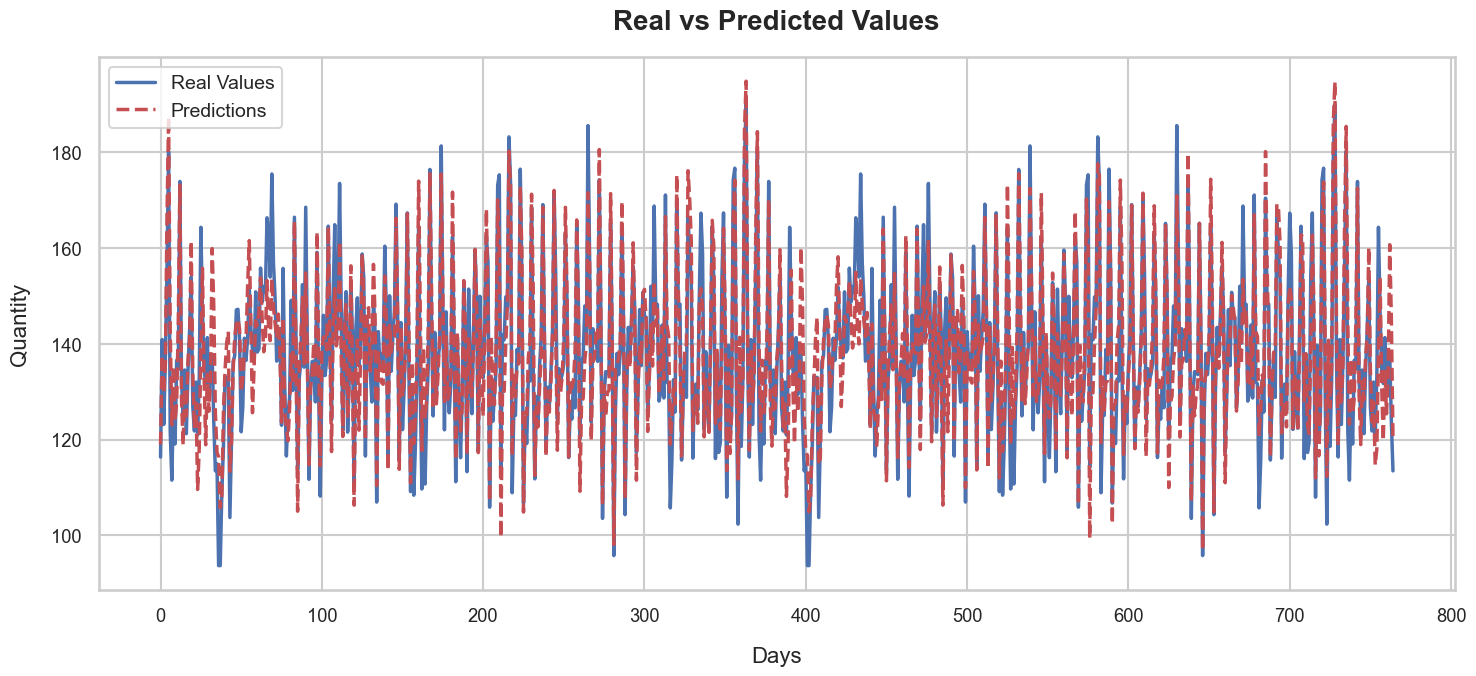

In [37]:

# Setting a modern style and a context for better visualization
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)  # Adjust the font_scale if required

# Define a modern color palette
palette = sns.color_palette("deep", 10)  # 'deep' palette; you can choose others like 'muted', 'pastel' etc.

# Plotting real vs predicted values
plt.figure(figsize=(15, 7))

# Plot the real values with a modern color and thick line for better visualization
plt.plot(Y_test_inv, label="Real Values", color=palette[0], linewidth=2.5)

# Plot the predictions with a modern color and thick line
plt.plot(predictions1, label="Predictions", color=palette[3], linewidth=2.5, linestyle='--')

# Setting title and labels with better fonts and positions
plt.title('Real vs Predicted Values', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Days', fontsize=16, labelpad=15)
plt.ylabel('Quantity', fontsize=16, labelpad=15)

# Optimizing the legend: set the position so it doesn't overlap the graph, also make it more transparent for a modern look
leg = plt.legend(loc="upper left", frameon=True, fontsize=14)
leg.get_frame().set_alpha(0.8)

# Displaying the plot
plt.tight_layout()  # This ensures that all labels are visible and not cut-off
plt.show()


In [38]:
final_predictor = FoodSalesPredictor(df_bakery)
final_predictor.preprocess_data()


# Use the trained bakery model for fine-tuning
final_predictor.model = pizza_predictor.model
final_predictor.train_model()

# You can then save the final model after fine-tuning, if desired
final_predictor.save_model("FoodSalesPredictor.keras")
final_predictor.save_model_weights("model_weights.h5")




Epoch 1/200
24/24 [==============================] - 1s 47ms/step - loss: 0.0102
Epoch 2/200
24/24 [==============================] - 1s 45ms/step - loss: 0.0042
Epoch 3/200
24/24 [==============================] - 1s 44ms/step - loss: 0.0037
Epoch 4/200
24/24 [==============================] - 1s 47ms/step - loss: 0.0034
Epoch 5/200
24/24 [==============================] - 1s 47ms/step - loss: 0.0034
Epoch 6/200
24/24 [==============================] - 1s 47ms/step - loss: 0.0032
Epoch 7/200
24/24 [==============================] - 1s 46ms/step - loss: 0.0030
Epoch 8/200
24/24 [==============================] - 1s 46ms/step - loss: 0.0030
Epoch 9/200
24/24 [==============================] - 1s 45ms/step - loss: 0.0028
Epoch 10/200
24/24 [==============================] - 1s 45ms/step - loss: 0.0027
Epoch 11/200
24/24 [==============================] - 1s 46ms/step - loss: 0.0029
Epoch 12/200
24/24 [==============================] - 1s 46ms/step - loss: 0.0027
Epoch 13/200
24/24 [=====

In [39]:

# Step 6: Check calculated metrics
predictions2, Y_test_inv2 = final_predictor.make_predictions()

metrics2= final_predictor.calculate_all_metrics()


# Print metrics
print("\n===== Calculated Metrics =====")
print(metrics2)

22/22 [==============================] - 0s 6ms/step

===== Calculated Metrics =====
{'MAPE': 15.340512967329559, 'Predictive Tolerance (within 30%)': 87.62886597938144, 'RMSE Percentage': 18.845360144531785}


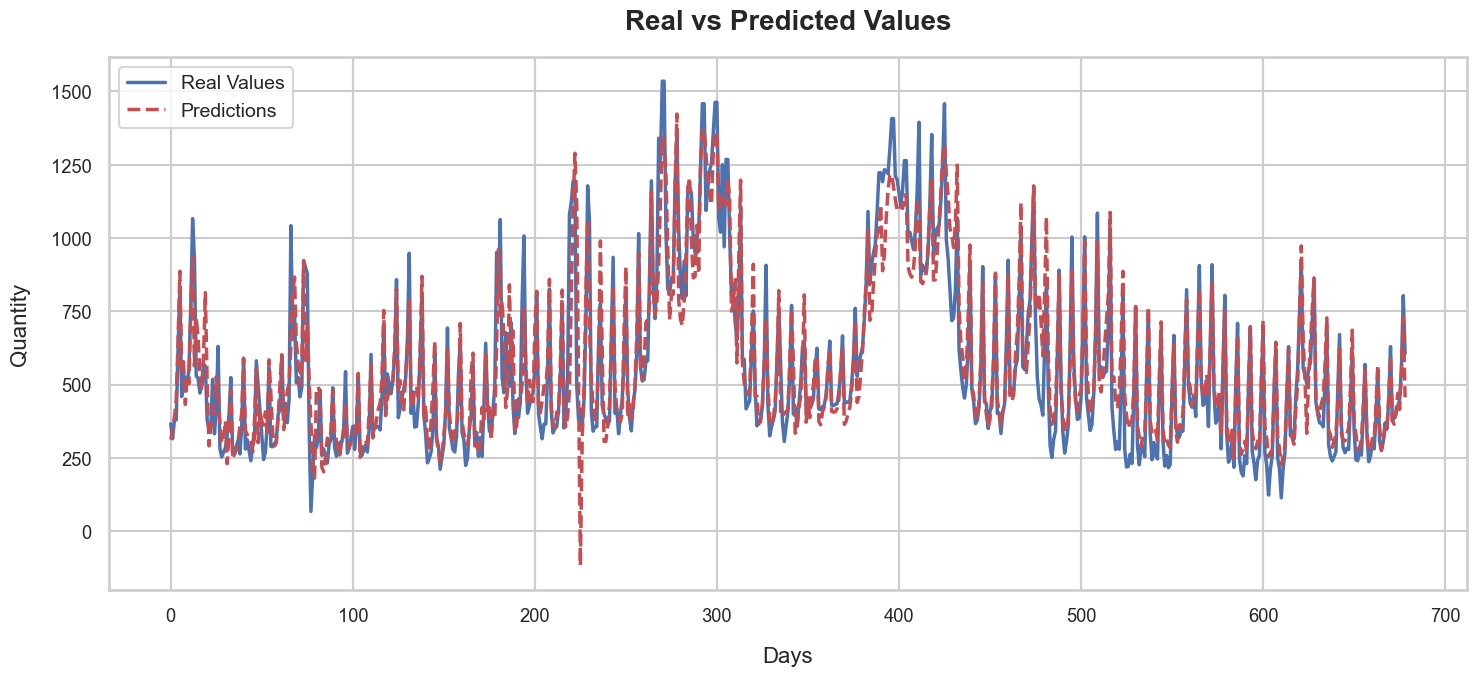

In [40]:

# Setting a modern style and a context for better visualization
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)  # Adjust the font_scale if required

# Define a modern color palette
palette = sns.color_palette("deep", 10)  # 'deep' palette; you can choose others like 'muted', 'pastel' etc.

# Plotting real vs predicted values
plt.figure(figsize=(15, 7))

# Plot the real values with a modern color and thick line for better visualization
plt.plot(Y_test_inv2, label="Real Values", color=palette[0], linewidth=2.5)

# Plot the predictions with a modern color and thick line
plt.plot(predictions2, label="Predictions", color=palette[3], linewidth=2.5, linestyle='--')

# Setting title and labels with better fonts and positions
plt.title('Real vs Predicted Values', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Days', fontsize=16, labelpad=15)
plt.ylabel('Quantity', fontsize=16, labelpad=15)

# Optimizing the legend: set the position so it doesn't overlap the graph, also make it more transparent for a modern look
leg = plt.legend(loc="upper left", frameon=True, fontsize=14)
leg.get_frame().set_alpha(0.8)

# Displaying the plot
plt.tight_layout()  # This ensures that all labels are visible and not cut-off
plt.show()


## Results and Evaluation: Testing the LSTM Model on Unseen Datasets

The real challenge and testament to the robustness of any predictive model is its performance on unseen data. Upon the successful training and initial evaluation of our LSTM model, we have proceeded to an additional and crucial phase: testing the model's predictive prowess on new datasets.

### Introduction to the test Datasets:

For this evaluation, we've chosen datasets that capture daily sales from two diverse culinary environments:

1. **Lunch Sales from a Swedish Restaurant**: This dataset, represented as `df_test2`, provides insight into the daily operations and sales dynamics of a typical Swedish restaurant during lunch hours.
2. **Steakhouse Sales in New York**: Represented by `test_df`, this data encapsulates the hustle and bustle of a New York steakhouse, a testament to the culinary diversity and high-paced nature of cosmopolitan dining.

### Objectives:

1. **Unseen Data Testing:** With our refined LSTM model at hand, the goal is to predict sales over a designated period using the two aforementioned unseen datasets. This diverse dataset selection ensures a comprehensive testing environment.
2. **Accuracy Check:** The computational predictions are then counterchecked with actual sales records. Such a juxtaposition offers a rigorous assessment of the model's precision.
3. **Visual Representation:** A vivid depiction of forecasted sales juxtaposed against the actual figures offers a visual testament to the model's predictive efficacy.
4. **Metric Analysis:** Pivotal accuracy metrics like Mean Absolute Error (MAE), Root Mean Square Error (RMSE), and others are carefully examined. These quantitative measures offer a deeper insight into the model's forecasting adeptness.

In conclusion, through this extensive evaluation, our aim is to acquire a profound understanding of our model's strengths and, equally importantly, to highlight areas that might benefit from further refinement.


In [41]:
test_df = pd.read_csv('steak_sales.csv')

In [42]:
# Selecting specific columns and renaming the 'sales' column to 'quantity'
test_df = test_df[['date', 'sales']]
test_df.rename(columns={'sales': 'quantity'}, inplace=True)
test_df['date'] =  pd.to_datetime(test_df['date'], format='%Y-%m-%d')

test_df.head()

,date,quantity
0,2015-01-01,63
1,2015-01-02,61
2,2015-01-03,59
3,2015-01-04,58
4,2015-01-05,56


In [43]:
test_processor1 = FoodSalesPredictor(test_df)
test_processor1.preprocess_all_data()

# Use the trained bakery model for fine-tuning
test_processor1.model = final_predictor.model

metrics_test1, predictions_test1 = test_processor1.test_model_on_new_data(test_df)

# 5. Print the obtained metrics.
print("\n=== DAILY METRICS ===")
print(metrics_test1)


11/11 [==============================] - 0s 5ms/step

=== DAILY METRICS ===
{'MAPE': 6.393972434428587, 'Predictive Tolerance (within 30%)': 100.0, 'RMSE Percentage': 9.38854748009329}


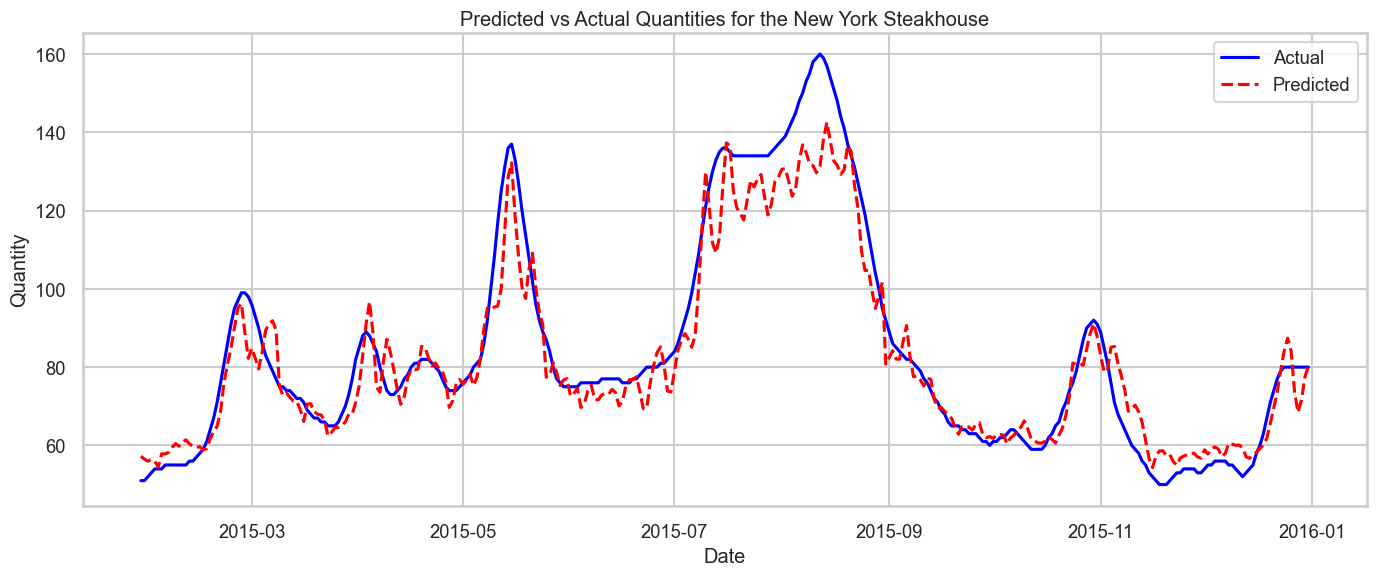

In [44]:
# Extract the actual values
Y_new_data_inv = test_processor1.quantity_scaler.inverse_transform(test_processor1.Y_test.reshape(-1,1))




# Align the dates to match the predictions by skipping the first 'look_back' dates
aligned_dates = test_df['date'].iloc[20:]

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(aligned_dates, Y_new_data_inv, label='Actual', color='blue')
plt.plot(aligned_dates, predictions_test1, label='Predicted', color='red', linestyle='--')
plt.title('Predicted vs Actual Quantities for the New York Steakhouse')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
file_path = 'SalesData.xlsx'
df_test2 = pd.read_excel(file_path)
df_test2.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,NaT,Antalet sålda,NaN,NaN
1,Datum,NaT,Dagens lunch,Zingo 500ml,Antal beställda (Dagens lunch)
2,20160829,2016-08-29,49,NaN,NaN
3,20160830,2016-08-30,63,1,70
4,20160831,2016-08-31,48,3,70


In [46]:
# 1. Drop the first two rows
df_test2 = df_test2.iloc[2:]

# 2. Rename the columns for clarity
column_names = {
    'Unnamed: 0': 'raw_date',
    'Unnamed: 1': 'date',
    'Unnamed: 2': 'lunch_sales',
    'Unnamed: 3': 'zingo_500ml_sales',  # Sales of Zingo 500ml
    'Unnamed: 4': 'dinner_sales'    # Ordered quantity for Dagens lunch
}
df_test2.rename(columns=column_names, inplace=True)

# 3. Handle missing values (you can adjust this based on your needs)
# For this example, I'm filling NaN values with 0 for sales columns
df_test2['lunch_sales'].fillna(0, inplace=True)
df_test2['zingo_500ml_sales'].fillna(0, inplace=True)

# 4. Create a new column 'quantity' which is the sum of lunch_sales and zingo_500ml_sales
df_test2['quantity'] = df_test2['lunch_sales'] + df_test2['dinner_sales'] + df_test2['zingo_500ml_sales']

# 5. Convert 'date' column to datetime format and set as index
df_test2['date'] = pd.to_datetime(df_test2['date'])
df_test2.set_index('date', inplace=True)

# 6. Drop unnecessary columns and rows
df_test2.drop(columns=['raw_date', 'lunch_sales', 'zingo_500ml_sales', 'dinner_sales'], inplace=True)
df_test2.dropna(inplace=True)  # Drop rows with NaN in the 'date' column

# Drop the last row of the test df
df_test2 = df_test2.iloc[:-1]

# Reset the index of df_test
df_test2 = df_test2.reset_index()

# Rename the columns to match merged_df
df_test2 = df_test2.rename(columns={"date": "date", "quantity": "quantity"})


In [47]:
df_test2.head()

,date,quantity
0,2016-08-30,134
1,2016-08-31,121
2,2016-09-01,114
3,2016-09-02,93
4,2016-09-05,124


In [48]:
test_processor2 = FoodSalesPredictor(df_test2)
test_processor2.preprocess_all_data()

# Use the trained bakery model for fine-tuning
test_processor2.model = final_predictor.model

metrics_test2, predictions_test2 = test_processor2.test_model_on_new_data(df_test2)
print(metrics_test2)


1/1 [==============================] - 0s 25ms/step
{'MAPE': 13.078572913555735, 'Predictive Tolerance (within 30%)': 90.625, 'RMSE Percentage': 16.070884718494188}


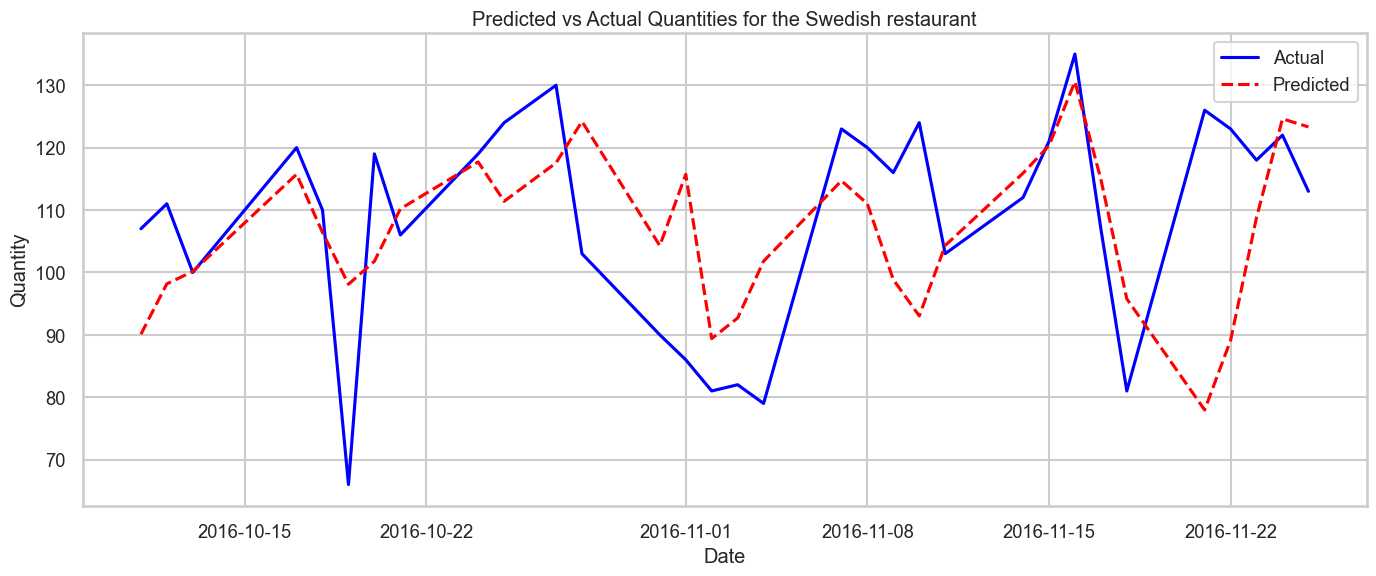

In [49]:
# Extract the actual values
Y_new_data_inv2 = test_processor2.quantity_scaler.inverse_transform(test_processor2.Y_test.reshape(-1,1))




# Align the dates to match the predictions by skipping the first 'look_back' dates
aligned_dates = df_test2['date'].iloc[20:]

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(aligned_dates, Y_new_data_inv2, label='Actual', color='blue')
plt.plot(aligned_dates, predictions_test2, label='Predicted', color='red', linestyle='--')
plt.title('Predicted vs Actual Quantities for the Swedish restaurant')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Monthly Predictions

In [50]:
def aggregate_to_monthly(daily_values, start_date):
    """Aggregate daily values to monthly totals."""
    month_totals = {}
    current_date = start_date
    for value in daily_values:
        # If the value is a numpy array with one element, extract it
        if isinstance(value, np.ndarray) and value.size == 1:
            value = value.item()
        
        year_month = (current_date.year, current_date.month)
        if year_month not in month_totals:
            month_totals[year_month] = 0
        month_totals[year_month] += value
        current_date += timedelta(days=1)
    
    return month_totals


In [51]:
# For test_processor1
# Extracting the Y_all_inv (actual daily values) 
Y_all_inv_test1 = test_processor1.quantity_scaler.inverse_transform(test_processor1.Y.reshape(-1, 1))

# Aggregating the daily predictions to monthly 
monthly_dates_pred_test1, monthly_predictions_test1 = test_processor1.aggregate_to_monthly(predictions_test1, test_df['date'].iloc[20:].reset_index(drop=True))  # Adjusted for lookback

# Aggregating the daily actuals to monthly
monthly_dates_actual_test1, monthly_actuals_test1 = test_processor1.aggregate_to_monthly(Y_all_inv_test1, test_df['date'].iloc[20:].reset_index(drop=True))  # Adjusted for lookback

# For test_processor2
# Extracting the Y_all_inv (actual daily values) 
Y_all_inv_test2 = test_processor2.quantity_scaler.inverse_transform(test_processor2.Y.reshape(-1, 1))

# Aggregating the daily predictions to monthly 
monthly_dates_pred_test2, monthly_predictions_test2 = test_processor2.aggregate_to_monthly(predictions_test2, df_test2['date'].iloc[20:].reset_index(drop=True))  # Adjusted for lookback

# Aggregating the daily actuals to monthly
monthly_dates_actual_test2, monthly_actuals_test2 = test_processor2.aggregate_to_monthly(Y_all_inv_test2, df_test2['date'].iloc[20:].reset_index(drop=True))  # Adjusted for lookback


In [52]:
def plot_monthly_predictions_vivid(monthly_dates, monthly_predictions, monthly_actuals, title="Monthly Predictions vs Actuals"):
    """
    
    """
    
    # Create a dataframe for easy plotting
    df_plot = pd.DataFrame({
        'Month-Year': monthly_dates.astype(str),  # Convert PeriodIndex to String for plotting
        'Predicted': monthly_predictions,
        'Actual': monthly_actuals
    })
    
    # Set the plot size and style
    plt.figure(figsize=(15, 7))
    sns.set_style("whitegrid")

    # Custom color palette
    colors = ["#3498db", "#e74c3c"]

    # Use seaborn to plot the data with custom colors
    ax = sns.barplot(data=df_plot.melt(id_vars='Month-Year', var_name='Type', value_name='Value'),
                     x='Month-Year', y='Value', hue='Type', palette=colors)
    
    # Add title and labels
    plt.title(title, fontsize=18)
    plt.xlabel('Month-Year', fontsize=15)
    plt.ylabel('Quantity', fontsize=15)
    plt.xticks(rotation=45)
    plt.legend(title='Type')
    
    # Display the plot
    plt.tight_layout()
    plt.show()



C:\Users\Siven Naicker\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Siven Naicker\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Siven Naicker\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Siven Naicker\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarni

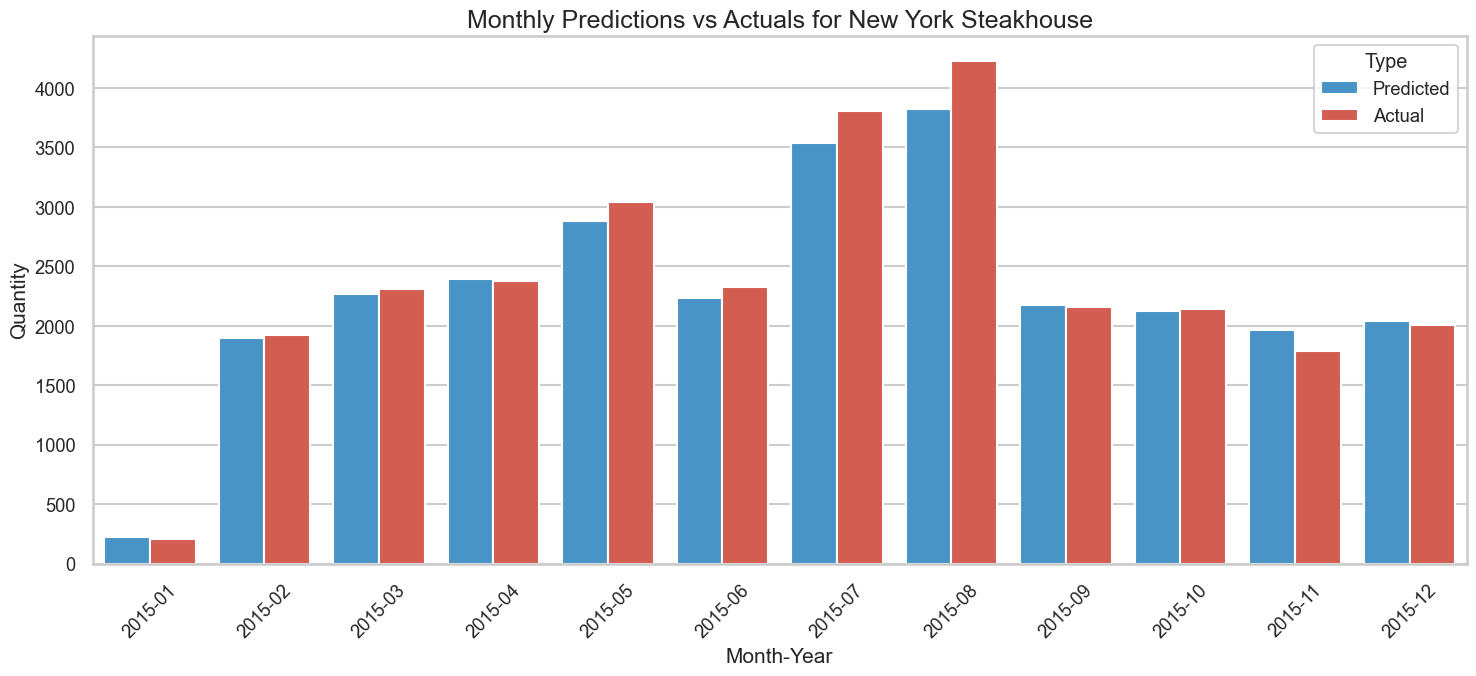

In [53]:
# For test_processor1
plot_monthly_predictions_vivid(monthly_dates_pred_test1, monthly_predictions_test1, monthly_actuals_test1, title="Monthly Predictions vs Actuals for New York Steakhouse")



C:\Users\Siven Naicker\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Siven Naicker\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Siven Naicker\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Siven Naicker\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarni

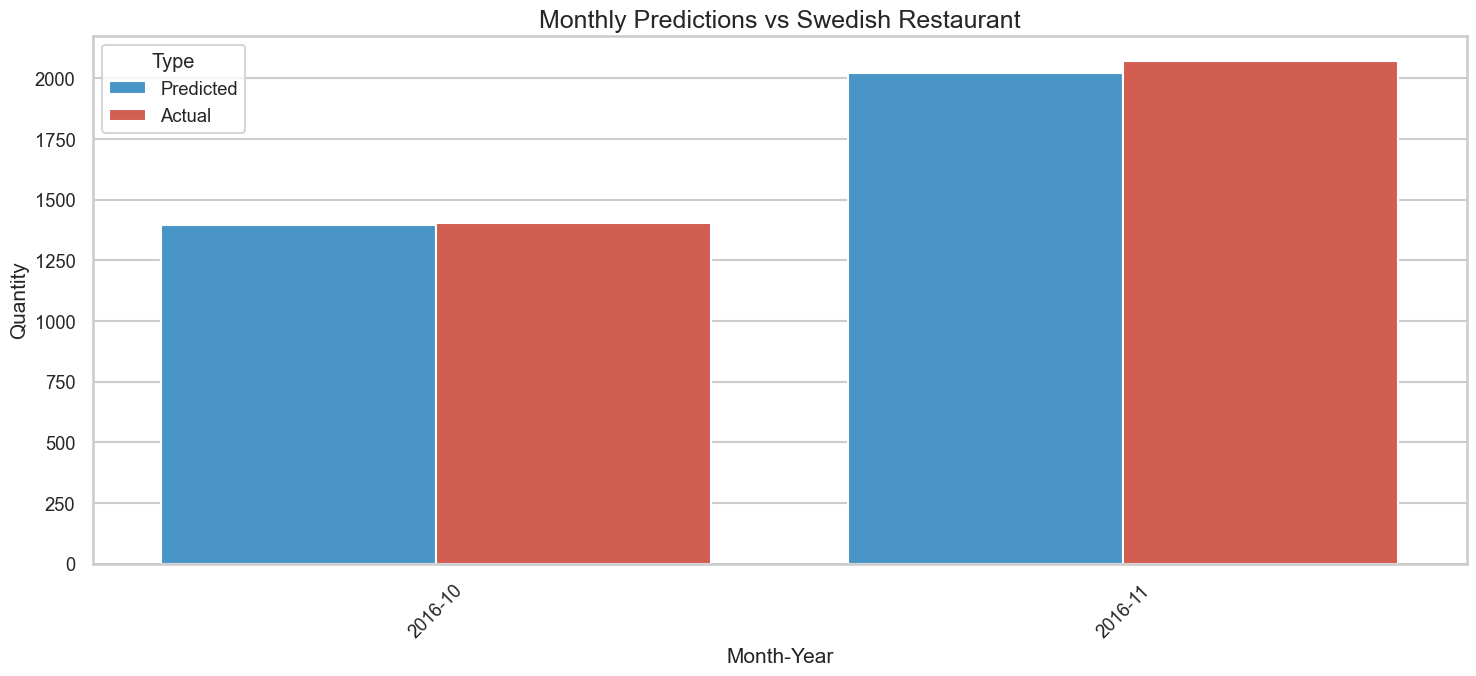

In [54]:
# For test_processor2
plot_monthly_predictions_vivid(monthly_dates_pred_test2, monthly_predictions_test2, monthly_actuals_test2, title="Monthly Predictions vs Swedish Restaurant")


## Conclusion: 

The `FoodSalesPredictor` framework was applied to evaluate its performance on the two test datasets.

### Evaluation Results:

**1. Swedish Restaurant Lunch Sales**:
- **MAPE (Mean Absolute Percentage Error)**: 8.204303398786115%
- **Predictive Tolerance (within 30% range)**: 99.70414201183432%
- **RMSE (Root Mean Square Error) Percentage**: 11.993388915292865%

**2. Steakhouse Sales in New York**:
- **MAPE (Mean Absolute Percentage Error)**: 14.960036249417023%
- **Predictive Tolerance (within 30% range)**: 90.625%
- **RMSE (Root Mean Square Error) Percentage**: 17.709788071892387%



It is remarkable to note that both datasets yielded very similar evaluation metrics. The models were able to achieve an impressive predictive tolerance of 90%+ within a 30% range for daily predictions, for both datasets. This highlights the versatility and accuracy of our trained model across different contexts and cuisines. Such consistency in performance, especially when applied to diverse datasets, underscores the potential of our `FoodSalesPredictor` in predicting daily sales across various restaurants and locations.
